# MLP interpretation and genetic interaction estimation

Some introductions here.

In [1]:
from utils.simulator import Simulator
from utils.saliency import approx_grad, approx_grad_array
from utils.plots import *

## Simulation
n=1000, p=5, 

beta_a = [3, -2, 0, 0, 0], 

interaction (15 terms): aa, ab, ac, ad, ae, bb, bc, bd, be, cc, cd, ce, dd, de, ee

beta_i = [0x5, 0x4, 0, 1, 0, 0x2, -1]

In [2]:
import numpy as np
import keras

# set global random seed
np.random.seed(111)

n = 2000
p = 5
beta_a = np.array([3, -2, 0, 0, 0]).astype('float32')
beta_i = np.array([0]*5 + [0]*4 + [0, 1, 0] + [0]*2 + [-1]).astype('float32')

simulator = Simulator(n=n, p=p, beta_a=beta_a, beta_i=beta_i)

X,y = simulator.sample_data()
X_test, y_test = simulator.sample_data()

def compute_mse_loss(y_pred, y_true):
	return np.mean(np.square(y_pred-y_true))


def print_eval_results(model, X_train, y_train, X_test, y_test):
	s = ''
	s += "train-set mse: %.3f\n" % compute_mse_loss(model.predict(X_train).flatten(), y_train)
	s += "test-set mse: %.3f\n" % compute_mse_loss(model.predict(X_test).flatten(), y_test)
	grad = approx_grad(model, X_train)
	s += "train feature effects: %s\n" % (','.join([str(round(x,3)) for x in grad]) )
	print(s)


/home/user/Programs/Anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Linear regression on first-order data (Maximum Likelihood estimator)

In [3]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression(fit_intercept=False)
lm.fit(X,y)

print_eval_results(lm, X, y, X_test, y_test)

train-set mse: 1.727
test-set mse: 1.747
train feature effects: 2.859,-2.096,0.865,0.905,-2.105



## Ridge linear regression (Shrinkage estimator)

In [4]:
from sklearn.linear_model import RidgeCV
# use RidgeCV to select the best regularization strength alpha through cross-validation
rlm = RidgeCV(alphas=[1e-2, 1e-1, 1., 5., 10., 100.], fit_intercept=False)
rlm.fit(X,y)
print("estimated alpha =",rlm.alpha_)

print_eval_results(rlm, X, y, X_test, y_test)

estimated alpha = 0.1
train-set mse: 1.727
test-set mse: 1.747
train feature effects: 2.859,-2.096,0.865,0.905,-2.105



It seems shrinkage is not doing much in this case, as expected. This is because in our data the number of samples is much larger than feature dimension $n\gg p$.

We can further plot the gradients $\frac{\partial Y}{\partial X_3}$ over $X_4$, which in theory should be a linear relationship if true data generating process is learned.

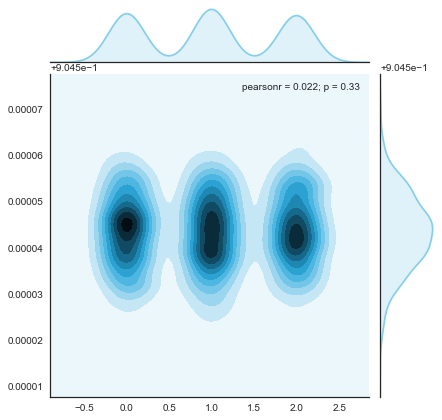

In [5]:
grad_arr_rlm = approx_grad_array(rlm, X)
#print(grad_arr_rlm[0:5, 0:5])
heatscatter_sns( rand_jitter(X[:,2], scale=0.05), rand_jitter(grad_arr_rlm[:,3], scale=10) ) # add some jitter on X-axis

Because there is no variance in `grad_arr_rlm[:,3]`, the scatter plot is only a line. 

## Shallow MLP

The shallow MLP has only one hidden layer with 3 units.

In [6]:
from keras.layers import Dense
from keras.callbacks import EarlyStopping
mlp1 = keras.models.Sequential()
mlp1.add(Dense(3, activation='relu', input_dim=5))
mlp1.add(Dense(1, activation='linear'))
mlp1.compile(loss='mse', optimizer='sgd')
mlp1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 18        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


So this model has 22 parameters, compared to a linear model with 5 parameters.

We fit the model with Stochatic Gradient Descent (SGD), with 10% of the data as validation data to monitor the overfitting status and early-stop.

In [7]:
mlp1.fit(X,y, epochs=1000, batch_size=100, verbose=0, validation_split=0.1, 
	callbacks=[EarlyStopping(monitor='val_loss', patience=100)])

print_eval_results(mlp1, X, y, X_test, y_test)

train-set mse: 1.312
test-set mse: 1.331
train feature effects: 2.906,-1.944,0.997,1.03,-1.938



Using the same input data, a shallow MLP can make more accurate predictions (smaller MSE). This is not overfitting because both train and test mse are comparably small.

How about the intepretability? Let's plot the the gradients $\frac{\partial Y}{\partial X_3}$ over $X_4$ to check:

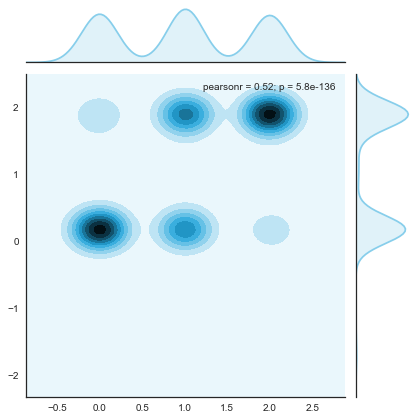

In [8]:
grad_arr_mlp1 = approx_grad_array(mlp1, X)
heatscatter_sns( rand_jitter(X[:,2], scale=0.05),  grad_arr_mlp1[:,3])

This is still kind of off, especially for $X_4=1$.

Let's see if we can resolve this by a deeper neural net.

## Deeper MLP

This deeper MLP has 3 hidden layers with 10, 10, 3 units respectively.

In [9]:
mlp2 = keras.models.Sequential()
mlp2.add(Dense(10, activation='relu', input_dim=5))
mlp2.add(Dense(10, activation='relu'))
mlp2.add(Dense(3, activation='relu'))
mlp2.add(Dense(1, activation='linear'))
mlp2.compile(loss='mse', optimizer='sgd')
mlp2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 33        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 4         
Total params: 207
Trainable params: 207
Non-trainable params: 0
_________________________________________________________________


So this model has 207 parameters, while the true data generating process has 2 main effects and 2 second-order interaction effects.

In [10]:
mlp2.fit(X,y, epochs=1000, batch_size=100, verbose=0, validation_split=0.1, 
	callbacks=[EarlyStopping(monitor='val_loss', patience=100)])

print_eval_results(mlp2, X, y, X_test, y_test)

train-set mse: 1.056
test-set mse: 1.137
train feature effects: 2.838,-1.895,0.963,0.948,-1.75



Because we added a standard normal error term ($\epsilon \sim N(0,1)$), the theoritical minimum mse is 1. This means the deeper mlp model overfits to the training data a bit, but almost also pushes to the limit of approximating the true data generating process.

Let's check this by interpreting the interaction term:

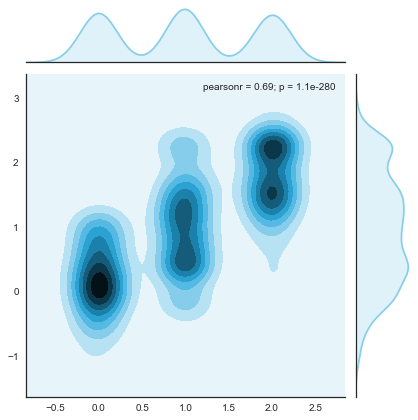

In [11]:
grad_arr_mlp2 = approx_grad_array(mlp2, X)

heatscatter_sns( rand_jitter(X[:,2], scale=0.05),  grad_arr_mlp2[:,3])